In [16]:
!pip install qiskit[visualization] qiskit-aer rustworkx scipy matplotlib qiskit_algorithms --quiet

In [17]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

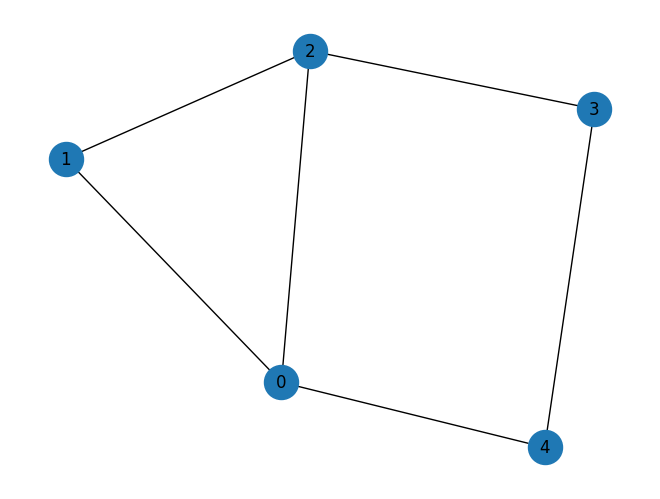

In [18]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [19]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, list[int], float]]:
    pauli_list = []
    for u, v in graph.edge_list():
        weight = graph.get_edge_data(u, v)
        pauli_list.append(("ZZ", [u, v], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, num_qubits=n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


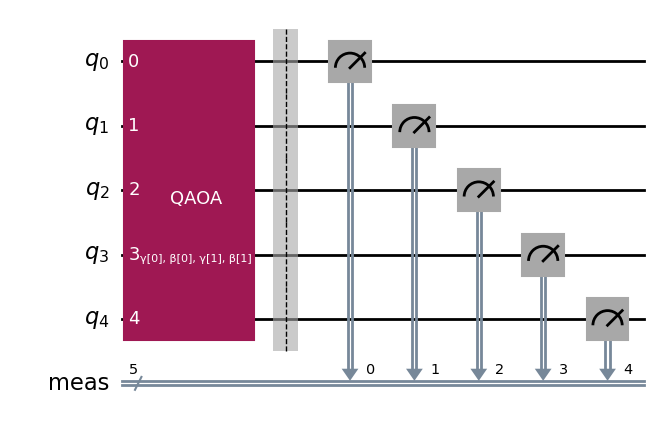

In [20]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
circuit.draw(output="mpl")

Using backend: AerSimulator('aer_simulator')


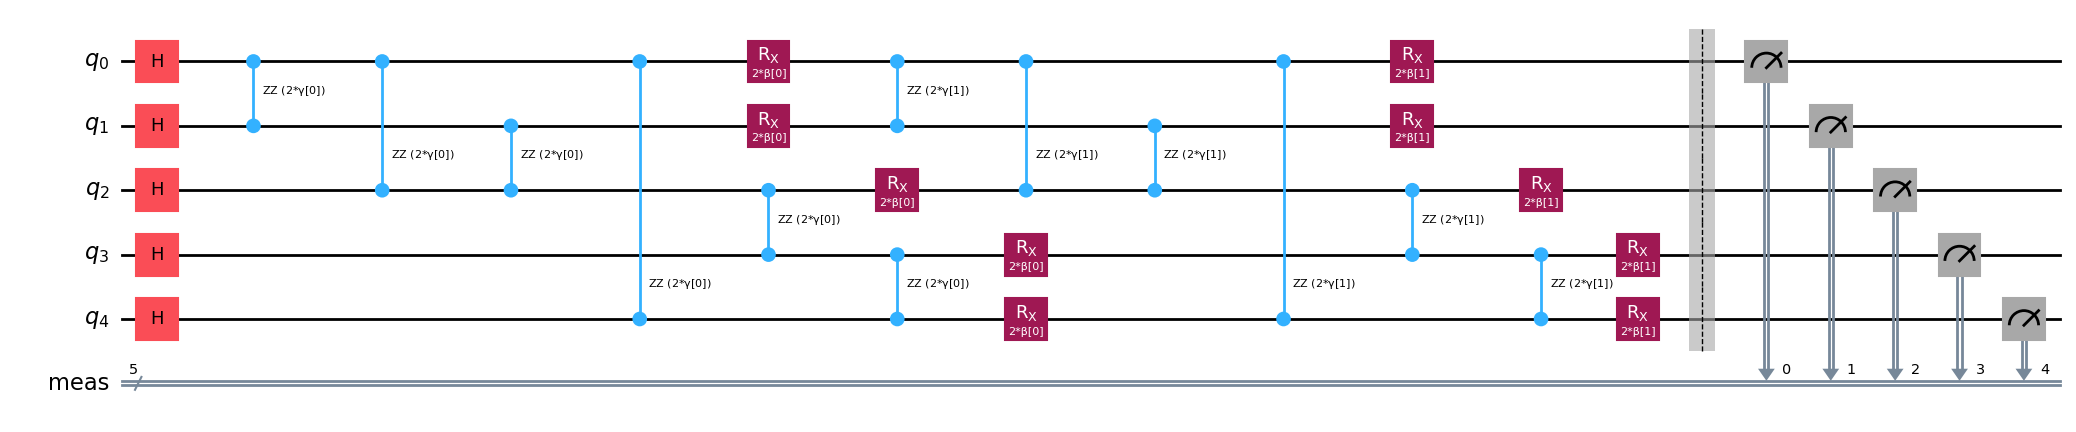

In [21]:
backend = AerSimulator()
print("Using backend:", backend)

# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# pm = generate_preset_pass_manager(optimization_level=3)
# candidate_circuit = pm.run(circuit)
# candidate_circuit = transpile(circuit, backend=backend, optimization_level=3)

# candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

from qiskit import transpile

candidate_circuit = transpile(circuit, backend=backend, optimization_level=3)
candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [22]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [23]:
objective_func_vals = []

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    job = estimator.run(
        circuits=[ansatz],
        observables=[hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, cost_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.73828125
       x: [ 1.753e+00  2.659e+00  3.740e+00  2.865e+00]
    nfev: 32
   maxcv: 0.0


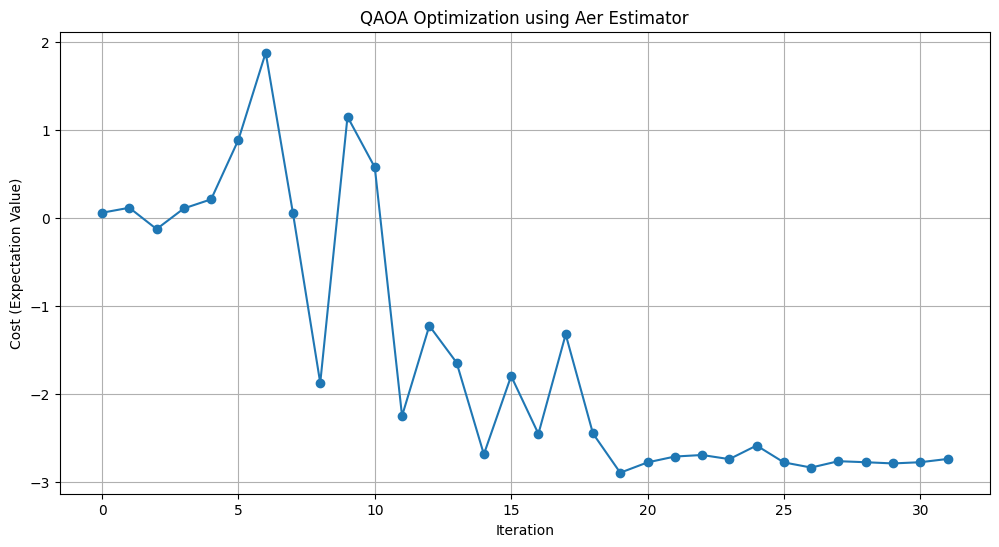

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title("QAOA Optimization using Aer Estimator")
plt.grid(True)
plt.show()

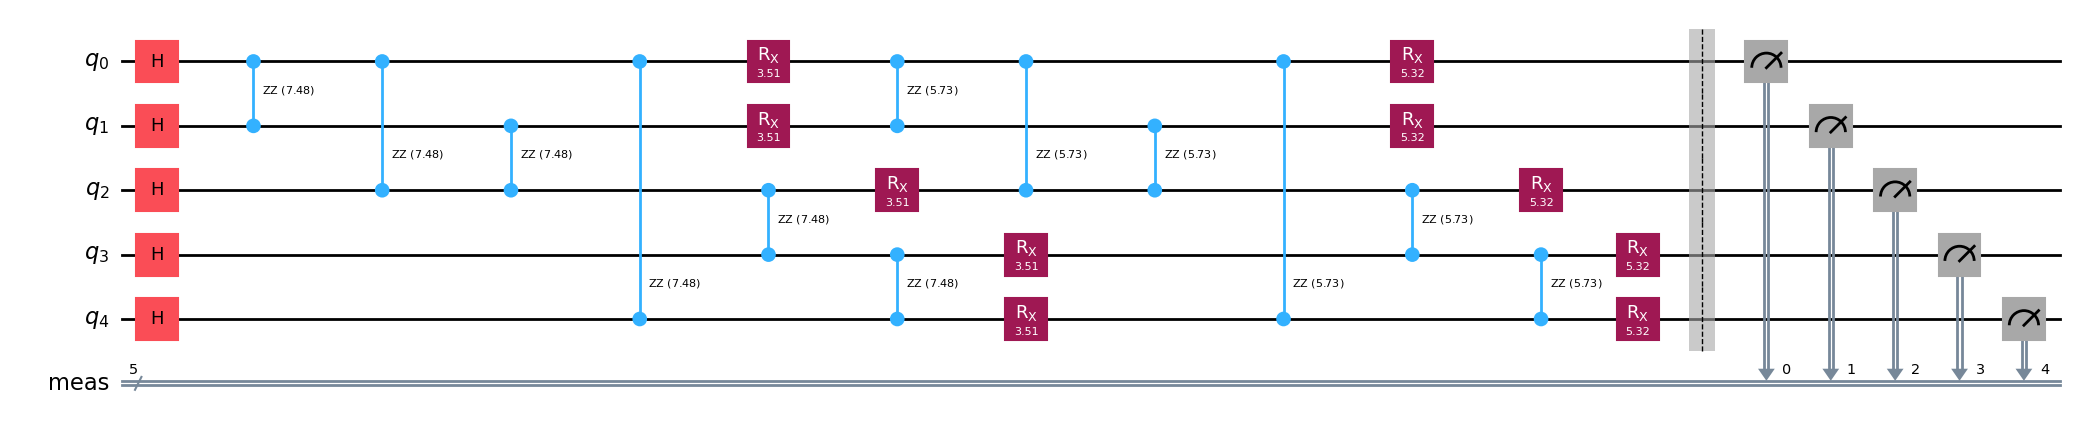

In [25]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [26]:
sampler = Sampler()
job = sampler.run([optimized_circuit], shots=10_000)
res = job.result()

quasi_dist = res.quasi_dists[0]
final_distribution_int = {}
for k, v in quasi_dist.items():
    if isinstance(k, str):
        final_distribution_int[int(k, 2)] = float(v)
    else:
        final_distribution_int[k] = float(v)
print(final_distribution_int)

{16: 0.0005, 18: 0.0524, 28: 0.0141, 21: 0.0531, 10: 0.0567, 5: 0.0632, 9: 0.1336, 26: 0.0633, 17: 0.011, 1: 0.0042, 6: 0.0117, 13: 0.0487, 22: 0.1328, 11: 0.1394, 23: 0.0003, 20: 0.1327, 8: 0.0002, 12: 0.0095, 25: 0.0148, 0: 0.0018, 3: 0.0131, 7: 0.0008, 19: 0.0099, 14: 0.0117, 30: 0.0058, 24: 0.0011, 4: 0.0057, 31: 0.0022, 27: 0.0043, 29: 0.0003, 15: 0.0003, 2: 0.0008}


In [27]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(values)]

most_likely_bitstring = to_bitstring(most_likely, n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 1, 0]


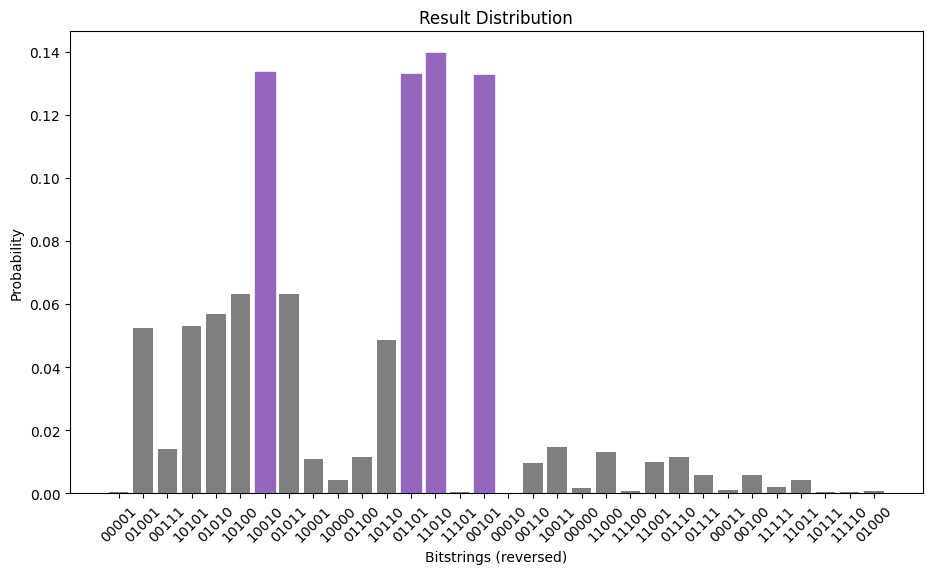

In [28]:
import matplotlib
matplotlib.rcParams.update({"font.size": 10})

bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
top_4_values = sorted(values, reverse=True)[:4]
positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

fig, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(bitstring_labels, values, color="tab:grey")
for p in positions:
    bars[p].set_color("tab:purple")

plt.show()

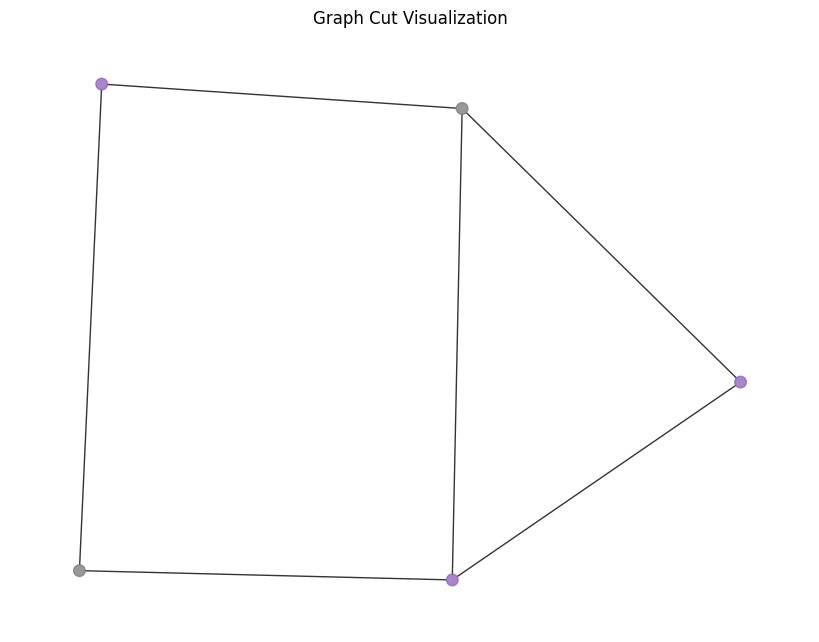

In [29]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

In [30]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "Length mismatch"
    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_val = evaluate_sample(most_likely_bitstring, graph)
print(f"The value of the cut is: {cut_val}")

The value of the cut is: 5
